# Extended Modeling with Deep Learning 
<br>
In this notebook we construct and execute multiple different renditions of a convolution neural net (CNN). We originally attempted to use transfer learning with the "ResNet50", "VGG16" and "EfficientNet B0 and B7" models. However, all four performed rather poorly when training on our spectrogram dataset. That being said, we decided to migrate towards building our own architecture of a CNN. The results were rather similar to the "state-of-the-art" models but we were able to experiment more with different layers, sizes, normalizations etc. Our first model was constructed using 12 million parameters and 8 weight layers. From there we applied various hyperparameter tunings by altering dropout levels and learning rates using KerasTuner. After realizing our tuning had minimal effect on the models performance we then tried experimenting with layer sizes and other types of optimizers.  

The complete results can be found at the end of the notebook.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.nn import weighted_cross_entropy_with_logits
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras.applications import ResNet50, VGG16

from keras_tuner.applications import HyperResNet
from keras_tuner.tuners import Hyperband, RandomSearch, BayesianOptimization
from keras_tuner import HyperModel

import tensorflow.keras_tuner
import warnings
import os
warnings.filterwarnings('ignore') 

2021-07-20 21:48:24.484309: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()

In [ ]:
# Create image generator from files/folders - rescale pixels
# Set batch sizes for training/testing 

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        './spec_pngs_train_OS3/train/',
        target_size=(251, 128),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)
test_set = test_datagen.flow_from_directory(
        './spec_pngs_train_OS3/val/',
        target_size=(251, 128),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)


print('Batches train=%d, test=%d' % (len(training_set), len(test_set)))

batchX, batchy = training_set.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 213271 images belonging to 3 classes.
Found 91404 images belonging to 3 classes.
Batches train=6665, test=2857
Batch shape=(32, 251, 128, 3), min=0.000, max=1.000


In [ ]:
NUM_CLASSES = 3 # bearish bullish neutral
INPUT_SHAPE = (251, 128, 3) # input shape

N_EPOCHS = 40
INIT_LR = 0.1

lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

OPTIMIZER = SGD(learning_rate=lr_schedule)
#OPTIMIZER = Adam(learning_rate=0.09)

model = Sequential()

# Block 1 Conv2D
model.add(Conv2D(32, (3,3), padding='same', input_shape=INPUT_SHAPE, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 2 Conv2D
model.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Block 3 Conv2D
model.add(Conv2D(128, (3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Fully Connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation='softmax'))


early_stopping = EarlyStopping(monitor='loss', patience=1)
checkpoint = ModelCheckpoint(filepath="SN.h5",
                             monitor="val_accuracy",
                             mode="max", 
                             save_best_only=True)


model.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
    

history = model.fit(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=N_EPOCHS,
                    validation_data=test_set,
                    callbacks=[early_stopping, checkpoint],
                    validation_steps=len(test_set),
                    workers=2,
                    verbose=1)

2021-07-20 21:50:10.136758: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-20 21:50:10.174431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-20 21:50:10.176898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0e:00.0 name: RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2021-07-20 21:50:10.176989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-20 21:50:10.178788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name

Epoch 1/40


2021-07-20 21:50:13.013781: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-20 21:50:13.700143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-07-20 21:50:14.518774: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-20 21:50:15.138065: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-20 21:50:15.413860: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6665/6665 [==============================] - 282s 42ms/step - loss: 1.0161 - accuracy: 0.5061 - val_loss: 0.9595 - val_accuracy: 0.5318
Epoch 2/40
6665/6665 [==============================] - 275s 41ms/step - loss: 0.9169 - accuracy: 0.5443 - val_loss: 1.0388 - val_accuracy: 0.4541
Epoch 3/40
6665/6665 [==============================] - 277s 41ms/step - loss: 0.8931 - accuracy: 0.5565 - val_loss: 1.4477 - val_accuracy: 0.4033
Epoch 4/40
6665/6665 [==============================] - 276s 41ms/step - loss: 0.8873 - accuracy: 0.5613 - val_loss: 0.9174 - val_accuracy: 0.5520
Epoch 5/40
6665/6665 [==============================] - 271s 41ms/step - loss: 0.8774 - accuracy: 0.5690 - val_loss: 1.0980 - val_accuracy: 0.4463
Epoch 6/40
6665/6665 [==============================] - 275s 41ms/step - loss: 0.8667 - accuracy: 0.5764 - val_loss: 2.0511 - val_accuracy: 0.3911
Epoch 7/40
6665/6665 [==============================] - 277s 42ms/step - loss: 0.8570 - accuracy: 0.5828 - val_loss: 0.9643 - val

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 251, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 251, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 251, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 251, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 64, 32)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 64, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 62, 64)       1

## Hyperparameter Tuning

Using the Tuner class in Keras we fine tune the hyperparameters of the model above. We pass arguments to the "RandomSearch" function within the models class as "HyperModel" and let the oracle function find the best parameters for the layers we want to tune. 

#### Tuned layers/parameters:
- Dropout (1 & 2)
- Conv2D (# of filters, last two -block 3)
- Dense (# of units)
- Learning rate (initial learning rate for "lr_schedule" with SGD optimizer)

In [ ]:
# Tuner class

class SpecNet(HyperModel):
    def __init__(self, input_shape, num_classes):#, num_epochs):
        self.input_shape = input_shape
        self.num_classes = num_classes
        #self.num_epochs = num_epochs
        
    def build(self, hp):
        lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=hp.Float(
                'initial_learning_rate',
                min_value=0.01,
                max_value=0.1,
                sampling='LOG',
                default=0.1
            ),
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True)

        OPTIMIZER = SGD(learning_rate=lr_schedule)


        model = Sequential()
        
        # Block 1 Conv2D
        model.add(Conv2D(32, (3,3), padding='same', input_shape=self.input_shape, activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        
        # Block 2 Conv2D
        model.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(BatchNormalization())
        
        # Block 3 Conv2D
        model.add(Conv2D(128, (3,3), padding='valid', activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='valid', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(BatchNormalization())
        
        # Fully Connected 
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(self.num_classes, activation='softmax'))


        early_stopping = EarlyStopping(monitor='loss', patience=1)
        checkpoint = ModelCheckpoint(filepath="SN.h5",
                                     monitor="val_accuracy",
                                     mode="max", 
                                     save_best_only=True)

        model.compile(optimizer=OPTIMIZER,
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
                         
        return model

In [ ]:
NUM_CLASSES = 3
INPUT_SHAPE = (251, 128, 3)

MAX_TRIALS = 15
EXECUTION_PER_TRIAL = 2
SEED = 44

hypermodelSN = SpecNet(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

randomsearchSN = RandomSearch(
    hypermodelSN,
    objective='val_loss',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='SNTune',
    project_name='randomsearchLast3'
)

randomsearchSN.search_space_summary()

Search space summary
Default search space size: 1
initial_learning_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.01, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
N_EPOCH_SEARCH = 1
randomsearchSN.search(training_set, validation_data=test_set, epochs=N_EPOCH_SEARCH)

Trial 15 Complete [00h 09m 28s]
val_loss: 1.453612208366394

Best val_loss So Far: 0.953913003206253
Total elapsed time: 02h 21m 55s
INFO:tensorflow:Oracle triggered exit


In [ ]:
randomsearchSN.results_summary()

Results summary
Results in SNTune/randomsearchLast3
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
initial_learning_rate: 0.01102975113618826
Score: 0.953913003206253
Trial summary
Hyperparameters:
initial_learning_rate: 0.012312318862783698
Score: 0.9883843660354614
Trial summary
Hyperparameters:
initial_learning_rate: 0.09245261253931152
Score: 1.0185049772262573
Trial summary
Hyperparameters:
initial_learning_rate: 0.03144391175271079
Score: 1.0190978050231934
Trial summary
Hyperparameters:
initial_learning_rate: 0.01166497940438329
Score: 1.0411848425865173
Trial summary
Hyperparameters:
initial_learning_rate: 0.018701455766499828
Score: 1.0785477757453918
Trial summary
Hyperparameters:
initial_learning_rate: 0.02561744893993957
Score: 1.1252598762512207
Trial summary
Hyperparameters:
initial_learning_rate: 0.017519340871097286
Score: 1.3219673037528992
Trial summary
Hyperparameters:
initial_learning_rate: 0.03808528106055659
Score

In [ ]:
best_model = randomsearchSN.get_best_models(num_models=1)[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 251, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 251, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 251, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 251, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 64, 32)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 64, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 62, 64)       1

In [ ]:
loss, accuracy = best_model.evaluate(test_set)

2857/2857 [==============================] - 77s 27ms/step - loss: 0.9341 - accuracy: 0.5358


In [ ]:
best_model_json = best_model.to_json()
with open("best_model_1.json", "w") as json_file:
    json_file.write(best_model_json)

In [ ]:
best_model.save_weights("best_model_1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
json_file = open('best_model_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model_1.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 251, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 251, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 251, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 251, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 64, 32)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 64, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 62, 64)       1

In [ ]:
checkpoint = ModelCheckpoint(filepath="SN_saved.h5",
                                     monitor="val_accuracy",
                                     mode="max", 
                                     save_best_only=True)

best_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False),
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

history = best_model.fit(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=40,
                    validation_data=test_set,
                    callbacks=[early_stopping, checkpoint],
                    validation_steps=len(test_set),
                    verbose=1)

## Experimental CNNs

Here, we build 3 models from scratch. The idea was to add depth to our previous model above and try new forms of regularization. We were planning for the added depth to reduce overfitting while allowing the NN to extract more unique features from our spectrograms.

- Model 1: Added new Conv2D layers with larger filter size
- Model 2: Kept depth but added dropout layers after each block
- Model 3: Removed dropout layer from fully connected

Different batch sizes were used for each, however, 512 seemed to produce the best results during training.

In [ ]:
%load_ext tensorboard

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomCrop, RandomFlip
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.nn import weighted_cross_entropy_with_logits
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras.applications import ResNet50, VGG16
import tensorflow_addons as tfa

import numpy as np
import datetime
import warnings
import os
warnings.filterwarnings('ignore') 

In [ ]:
def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):

    # create RAdam optimizer
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    # feed RAdam optimizer into lookahead operation
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim

In [6]:
# Initiate same type of image gen - rescale pixels ..  for all CNNs
# New batch size (512)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
     './spec_pngs_train_OS3/train/',
     target_size=(128, 251),
     batch_size=512,
     #shuffle=True,
     class_mode='categorical')
test_set = test_datagen.flow_from_directory(
     './spec_pngs_train_OS3/val/',
     target_size=(128, 251),
     batch_size=512,
     #shuffle=True,
     class_mode='categorical')


print('Batches train=%d, test=%d' % (len(training_set), len(test_set)))

batchX, batchy = training_set.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

In [ ]:
NUM_CLASSES = 3
INPUT_SHAPE = (128, 251, 3)

N_EPOCHS = 40
OPTIMIZER = Ranger(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=0.01, amsgrad=False)


cnnspec = Sequential()

# Block 1 Conv2D
cnnspec.add(Conv2D(32, (3,3), padding='same', input_shape=INPUT_SHAPE, activation='relu'))
cnnspec.add(Conv2D(32, (3,3), padding='same', activation='relu'))
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))

# Block 2 Conv2D
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))
cnnspec.add(BatchNormalization())

# Block 3 Conv2D
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))
cnnspec.add(BatchNormalization())

# Block 4 Conv2D
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))
cnnspec.add(BatchNormalization())

# Fully Connected
cnnspec.add(Flatten())
cnnspec.add(Dense(512, activation='relu'))
cnnspec.add(Dense(256, activation='relu'))
cnnspec.add(Dense(64, activation='relu'))
cnnspec.add(Dropout(0.4))
cnnspec.add(Dense(NUM_CLASSES, activation='softmax'))


early_stopping = EarlyStopping(monitor='loss', patience=1)
checkpoint = ModelCheckpoint(filepath="SN.h5",
                             monitor="val_accuracy",
                             mode="max", 
                             save_best_only=True)

cnnspec.compile(optimizer=OPTIMIZER,
               loss='categorical_crossentropy', 
               metrics=['accuracy'])
    

history = cnnspec.fit_generator(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=N_EPOCHS,
                    validation_data=test_set,
                    callbacks=[early_stopping, checkpoint],
                    validation_steps=len(test_set),
                    workers=2,
                    verbose=1)

2021-07-22 16:15:33.443573: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-22 16:15:33.444152: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499970000 Hz


Epoch 1/40


2021-07-22 16:15:40.277368: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-22 16:15:40.941855: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-07-22 16:15:41.755114: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-22 16:15:42.361648: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-22 16:15:43.179062: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1667/1667 [==============================] - 302s 174ms/step - loss: 1.0322 - accuracy: 0.4655 - val_loss: 1.1310 - val_accuracy: 0.4021
Epoch 2/40
1667/1667 [==============================] - 290s 174ms/step - loss: 0.9385 - accuracy: 0.5286 - val_loss: 1.1824 - val_accuracy: 0.4271
Epoch 3/40
1667/1667 [==============================] - 289s 173ms/step - loss: 0.9193 - accuracy: 0.5355 - val_loss: 0.9297 - val_accuracy: 0.5383
Epoch 4/40
1667/1667 [==============================] - 289s 174ms/step - loss: 0.9123 - accuracy: 0.5406 - val_loss: 0.9056 - val_accuracy: 0.5452
Epoch 5/40
1667/1667 [==============================] - 292s 175ms/step - loss: 0.9056 - accuracy: 0.5441 - val_loss: 0.9092 - val_accuracy: 0.5517
Epoch 6/40
1667/1667 [==============================] - 291s 175ms/step - loss: 0.9008 - accuracy: 0.5475 - val_loss: 1.0394 - val_accuracy: 0.4181
Epoch 7/40
1667/1667 [==============================] - 293s 176ms/step - loss: 0.8951 - accuracy: 0.5491 - val_loss: 0.992

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

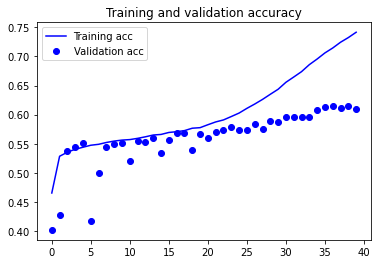

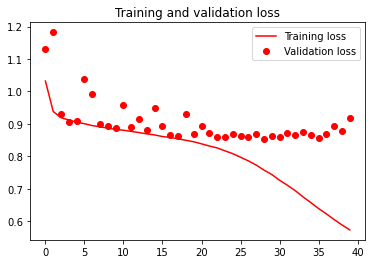

In [ ]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
cnnspec.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 251, 128, 32)      896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 251, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 125, 64, 32)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 125, 64, 32)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 123, 62, 64)       18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 123, 62, 64)       256       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 121, 60, 64)      

In [2]:
loss, accuracy = cnnspec.evaluate(test_set)

2857/2857 [==============================] - 77s 38ms/step - loss: 0.8658 - accuracy: 0.5871


In [ ]:
cnnspec.save('cnnspec_v1.h5')

In [ ]:
# Same model as 1st, includes dropout layers though.

NUM_CLASSES = 3
INPUT_SHAPE = (128, 251, 3)

N_EPOCHS = 40
OPTIMIZER = Ranger(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=0.01, amsgrad=False)

cnnspec = Sequential()

# Block 1 Conv2D
cnnspec.add(Conv2D(32, (3,3), padding='same', input_shape=INPUT_SHAPE, activation='relu'))
cnnspec.add(Conv2D(32, (3,3), padding='same', activation='relu'))
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))

# Block 2 Conv2D
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))
cnnspec.add(BatchNormalization())

# Block 3 Conv2D
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))
cnnspec.add(BatchNormalization())

# Block 4 Conv2D
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))
cnnspec.add(BatchNormalization())

# Fully Connected
cnnspec.add(Flatten())
cnnspec.add(Dense(512, activation='relu'))
cnnspec.add(Dense(256, activation='relu'))
cnnspec.add(Dense(64, activation='relu'))
cnnspec.add(Dropout(0.5))
cnnspec.add(Dense(NUM_CLASSES, activation='softmax'))


early_stopping = EarlyStopping(monitor='loss', patience=1)
checkpoint = ModelCheckpoint(filepath="SN.h5",
                             monitor="val_accuracy",
                             mode="max", 
                             save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

cnnspec.compile(optimizer=OPTIMIZER,
               loss='categorical_crossentropy', 
               metrics=['accuracy'])
    

history = cnnspec.fit_generator(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=N_EPOCHS,
                    validation_data=test_set,
                    callbacks=[early_stopping, checkpoint, reduce_lr],
                    validation_steps=len(test_set),
                    workers=2,
                    verbose=1)

2021-07-22 23:14:27.561067: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-22 23:14:27.598138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-22 23:14:27.600202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0e:00.0 name: RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2021-07-22 23:14:27.600307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-22 23:14:27.602461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name

Epoch 1/40


2021-07-22 23:14:36.315827: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-22 23:14:37.031363: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-07-22 23:14:37.885369: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-22 23:14:38.492044: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-22 23:14:39.304724: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1667/1667 [==============================] - 305s 177ms/step - loss: 1.0460 - accuracy: 0.4580 - val_loss: 1.3931 - val_accuracy: 0.4021
Epoch 2/40
1667/1667 [==============================] - 292s 175ms/step - loss: 0.9510 - accuracy: 0.5225 - val_loss: 1.0418 - val_accuracy: 0.4768
Epoch 3/40
1667/1667 [==============================] - 296s 178ms/step - loss: 0.9247 - accuracy: 0.5356 - val_loss: 0.9647 - val_accuracy: 0.5164
Epoch 4/40
1667/1667 [==============================] - 294s 176ms/step - loss: 0.9145 - accuracy: 0.5392 - val_loss: 0.9286 - val_accuracy: 0.5329
Epoch 5/40
1667/1667 [==============================] - 309s 185ms/step - loss: 0.9085 - accuracy: 0.5427 - val_loss: 0.9136 - val_accuracy: 0.5441
Epoch 6/40
1667/1667 [==============================] - 295s 177ms/step - loss: 0.9038 - accuracy: 0.5441 - val_loss: 0.9327 - val_accuracy: 0.5393
Epoch 7/40
1667/1667 [==============================] - 295s 177ms/step - loss: 0.9000 - accuracy: 0.5454 - val_loss: 0.908

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

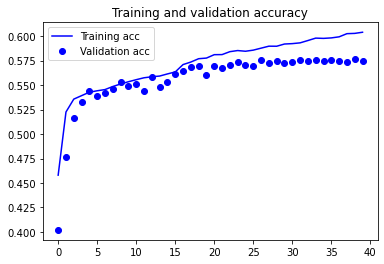

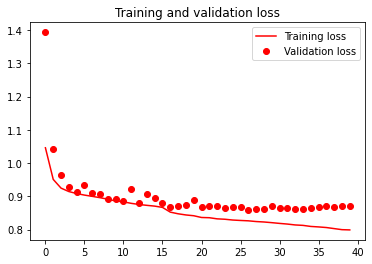

In [ ]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
cnnspec.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 251, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 251, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 64, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 64, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 62, 64)       18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 123, 62, 64)       256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 60, 64)       3

In [7]:
loss, accuracy = cnnspec.evaluate(test_set)

2857/2857 [==============================] - 68s 42ms/step - loss: 0.8323 - accuracy: 0.6192


In [ ]:
cnnspec.save('cnnspec_v2.h5')

In [ ]:
# Removed dropout in fully connected layer

NUM_CLASSES = 3
INPUT_SHAPE = (251, 128, 3)

N_EPOCHS = 40
OPTIMIZER = Ranger(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=0.01, amsgrad=False)

cnnspec = Sequential()

# Block 1 Conv2D
cnnspec.add(Conv2D(32, (3,3), padding='same', input_shape=INPUT_SHAPE, activation='relu'))
cnnspec.add(Conv2D(32, (3,3), padding='same', activation='relu'))
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))

# Block 2 Conv2D
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))
cnnspec.add(BatchNormalization())

# Block 3 Conv2D
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(64, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))
cnnspec.add(BatchNormalization())

# Block 4 Conv2D
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(BatchNormalization())
cnnspec.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
cnnspec.add(MaxPooling2D(pool_size=(2,2)))
cnnspec.add(Dropout(0.4))
cnnspec.add(BatchNormalization())

# Fully Connected
cnnspec.add(Flatten())
cnnspec.add(Dense(512, activation='relu'))
cnnspec.add(Dense(256, activation='relu'))
cnnspec.add(Dense(64, activation='relu'))
#cnnspec.add(Dropout(0.2))
cnnspec.add(Dense(NUM_CLASSES, activation='softmax'))


early_stopping = EarlyStopping(monitor='loss', patience=1)
checkpoint = ModelCheckpoint(filepath="SN.h5",
                             monitor="val_accuracy",
                             mode="max", 
                             save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

cnnspec.compile(optimizer=OPTIMIZER,
               loss='categorical_crossentropy', 
               metrics=['accuracy'])
    
history = cnnspec.fit_generator(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=N_EPOCHS,
                    validation_data=test_set,
                    callbacks=[early_stopping, checkpoint],
                    validation_steps=len(test_set),
                    workers=2,
                    verbose=1)

2021-07-23 14:18:20.790471: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-23 14:18:20.822591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-23 14:18:20.824164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0e:00.0 name: RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2021-07-23 14:18:20.824231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-23 14:18:20.825844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name

Epoch 1/40


2021-07-23 14:18:29.352949: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-23 14:18:30.059280: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-07-23 14:18:30.906663: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-23 14:18:31.529172: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-23 14:18:32.342201: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1667/1667 [==============================] - 307s 178ms/step - loss: 1.0100 - accuracy: 0.4769 - val_loss: 1.6762 - val_accuracy: 0.4021
Epoch 2/40
1667/1667 [==============================] - 294s 176ms/step - loss: 0.9221 - accuracy: 0.5354 - val_loss: 0.9740 - val_accuracy: 0.5242
Epoch 3/40
1667/1667 [==============================] - 296s 177ms/step - loss: 0.9055 - accuracy: 0.5430 - val_loss: 0.9596 - val_accuracy: 0.5376
Epoch 4/40
1667/1667 [==============================] - 294s 177ms/step - loss: 0.8987 - accuracy: 0.5464 - val_loss: 1.0589 - val_accuracy: 0.4586
Epoch 5/40
1667/1667 [==============================] - 293s 176ms/step - loss: 0.8949 - accuracy: 0.5495 - val_loss: 0.9160 - val_accuracy: 0.5397
Epoch 6/40
1667/1667 [==============================] - 296s 178ms/step - loss: 0.8908 - accuracy: 0.5517 - val_loss: 0.9843 - val_accuracy: 0.4900
Epoch 7/40
1667/1667 [==============================] - 298s 179ms/step - loss: 0.8866 - accuracy: 0.5548 - val_loss: 0.895

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

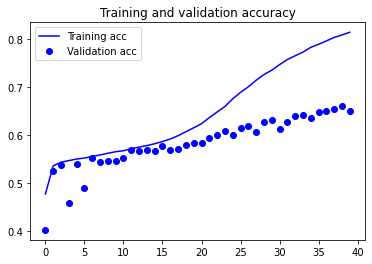

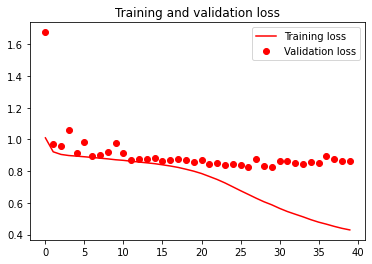

In [ ]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [5]:
loss, accuracy = cnnspec.evaluate(test_set)

2857/2857 [==============================] - 89s 32ms/step - loss: 0.8134 - accuracy: 0.6345


In [ ]:
cnnspec.save('cnnspec_v3.h5')

## Conclusion and Findings

Overall, we built 4 unique models using the CNN framework. Based on our initial test from our first rendition we received results that were clearly overfit around epoch 15. In order to remedy this we first tried to tune its hyperparameters using the "RandomSearch" method of "KerasTuner." We attempted to modify parameters like learning rate and the "Dropout" amount. However, there was not much change in model outcome...overfitting was still extremely present. After trying those different possibilities we then decided to try different model archetectures.

Out of the 3 experimental architectures, we found that overfitting was still a problem, although it was best mitigated in "v2". Where the overfitting doesn't start until reaching epoch 20 or so. Even though we were able to attain slightly better results with the newer versions, our loss was consistently flat-lining after x amount of epochs. Because this was a constant throughout our experimentation we might conclude that our model was not learning from our data at all or that the data could possibly be too complex. If the data was to complex we might be required to increase layers and network depth to extract features that are more unique to the 3 classes we have, requiring more training time and resources which would be rather expensive in the long run. 

However, working within the constraints of time and resources we tested the majority of potential architectures and frameworks and could not break above 70% accuracy without heavy overfitting/underfitting. The final conclusion we came to is that our original dataset needs to be reworked in a way that is better able to be processed by a neural net. Whether that means a re-balancing, using images in a different color mode or a new type of augmentation technique, it will be reserved for future work. 

### Possible Issues:
- Models not learning, only memorizing
- Data problems
    - Unbalanced
    - Too complex for architecture?